## IFT6269 - Homework 5 - Number 2

#### Gibbs sampling and mean field variational inference

We consider the Ising model with binary variables $X_s \in \{0,1\}$ and a factorization of the form:

$$ p(x;\eta) = \frac{1}{Z_p} \exp \left( \sum_{s \in V} \eta_s x_s + \sum_{\{s,t\} \in E} \eta_{st} x_s x_t \right) $$

We also consider the $7 \times 7$ 2D grid as shown here :

<img src="https://i.imgur.com/hvxEFjs.png" alt="Drawing" style="width: 250px;"/>

We will consider approximate inference methods to approximate the node marginal moments $\mu_s := p(X_s = 1)$ in this model.

Below is an implementation of the Gibbs sampling updates and the naife mean field updates for the model. Refer to the paper document for the derivation of both updates.


In [392]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""
Author : Patrice Bechard
E-mail : bechardpatrice@gmail.com
Date created : November 23, 2017
"""

'\nAuthor : Patrice Bechard\nE-mail : bechardpatrice@gmail.com\nDate created : November 23, 2017\n'

In [393]:
# importing modules

%pylab inline
%config IPCompleter.greedy=True #enable autocomplete
import numpy as np
import matplotlib.pyplot as plt
import sys

Populating the interactive namespace from numpy and matplotlib


In [394]:
class IsingGibbs:
    
    def __init__(self, grid_dims):    
        """
        Parameters
        ----------
        grid_dims : array-like, [nx, ny]
            dimensions of the grid
        """
        
        self.grid_dims = grid_dims
        self.n_nodes = np.prod(grid_dims)
        
        self.grid = np.zeros(self.grid_dims)
        
        self.eta_nodes = np.array([(-1.)**s for s in range(self.n_nodes)])
        self.eta_nodes = np.reshape(self.eta_nodes, self.grid_dims)
        self.eta_edges = 0.5                # same for all edges   
        
    def _random_init_grid(self):
        """ Initializing grid randomly """
        self.grid = np.random.randint(2, size=self.grid_dims).astype('float32')

    def _gibbs_sampling_epoch(self):
        """ 
        Updating each node of the model once using a Gibbs sampling approach
        """
        
        for i in range(self.grid_dims[0]):
            for j in range(self.grid_dims[1]):
            
                node_contrib = self.eta_nodes[i,j]
            
                neighbors = np.array([[i-1, j],
                                     [(i+1)%self.grid_dims[0], j],
                                     [i, j-1],
                                     [i, (j+1)%self.grid_dims[1]]])
                
                neighbors_contrib = self.eta_edges * sum([self.grid[k[0],k[1]] 
                                                          for k in neighbors])

                prob = sigmoid(node_contrib + neighbors_contrib)

                if np.random.random() < prob:
                    self.grid[i,j] = 1
                else:
                    self.grid[i,j] = 0

    def gibbs_sampling(self, n_burn_in_epochs, n_epochs, n_rep_stddev):
        """
        Updating the model to find the mean estimate and its variance 
        for each node
        
        Parameters
        ----------
        n_burn_in_epochs: int
            number of epochs for which we perform burn-in
        n_epochs: int
            number of epochs for which we collect a sample vector
            to compute the mean Monte Carlo estimate
        n_rep_stddev: int
            number of times we repeat the inference using Gibbs Sampling
            to have an estimate of the standard deviation of our estimates
        """
        
        for rep in range(n_rep_stddev):

            #initialize grid randomly
            self._random_init_grid()
            
            # burn-in
            for epoch in range(n_burn_in_epochs):
                self._gibbs_sampling_epoch()

            collection = np.array([])
            
            # sampling
            for epoch in range(n_epochs):
                
                self._gibbs_sampling_epoch()

                if epoch == 0:
                    collection = np.expand_dims(self.grid, axis=0)
                else:
                    collected_sample = np.expand_dims(self.grid, axis=0)
                    collection = np.append(collection, 
                                           collected_sample, 
                                           axis=0)

            mean_estimate = np.sum(collection, axis=0) / n_epochs

            if rep == 0:
                mean_collection = np.expand_dims(mean_estimate, axis=0)
            else:
                mean_collection = np.append(mean_collection,
                                            np.expand_dims(mean_estimate, axis=0),
                                            axis=0)
        
        stddev_estimate = np.std(mean_collection, axis=0)
        
        np.savetxt('latex/data/mean_grid_gibbs.txt', mean_estimate, fmt='%.4e')
        np.savetxt('latex/data/stddev_grid_gibbs.txt', stddev_estimate, fmt='%.4e')
        
        print("Mean estimate for Gibbs sampling:")
        print(mean_estimate)
        plt.imshow(mean_estimate, cmap='viridis', vmin=0., vmax=1.)
        plt.colorbar(orientation='vertical')
        plt.savefig('latex/figures/mean_gibbs.png')
        plt.show()
        plt.clf()

        print("Standard deviation estimate for Gibbs sampling:")
        print(stddev_estimate)
        plt.imshow(stddev_estimate, cmap='viridis')
        plt.colorbar(orientation='vertical')
        plt.savefig('latex/figures/stddev_gibbs.png')
        plt.show()
        plt.clf()
        
        return mean_estimate
        

In [395]:
class IsingMeanField:
    
    def __init__(self, grid_dims):
        """
        Parameters
        ----------
        grid_dims : array-like, [nx, ny]
            dimensions of the grid
        """
        
        self.grid_dims = grid_dims
        self.n_nodes = np.prod(grid_dims)
        
        self.grid = np.zeros(self.grid_dims)
        
        self.eta_nodes = np.array([(-1.)**s for s in range(self.n_nodes)])
        self.eta_nodes = np.reshape(self.eta_nodes, self.grid_dims)
        self.eta_edges = 0.5                # same for all edges   
    
    def _random_init_grid(self):
        """ Initializing grid randomly """
        self.grid = np.random.random(size=self.grid_dims)
    
    def _mean_field_epoch(self):
        """ 
        Updating grid for all nodes once using a variational inference approach
        """
        
        for i in range(self.grid_dims[0]):
            for j in range(self.grid_dims[1]):
            
                node_contrib = self.eta_nodes[i,j]
            
                neighbors = np.array([[i-1, j],
                                     [(i+1)%self.grid_dims[0], j],
                                     [i, j-1],
                                     [i, (j+1)%self.grid_dims[1]]])

                neighbors_contrib = self.eta_edges * sum([self.grid[k[0],k[1]] 
                                                          for k in neighbors])

                self.grid[i,j] = sigmoid(node_contrib + neighbors_contrib)
    
    def mean_field(self, n_rep, stopping_criterion = 0.001):
        """ 
        Updating grid until convergence and 
        plotting evolution of KL divergence 
        
        Parameters
        ----------
        n_rep : int
            number of times we initialize a new grid to perform
            variational inference on.
        stopping_criterion : float
            convergence criterion for the L1 distance between
            two successive grids after one epoch
        """
        
        for rep in range(n_rep):
            
            self._random_init_grid()
            kl_values = np.array([self.kl_divergence()])
            
            old_grid = np.ones_like(self.grid) * 1e9     #dummy value

            while l1_distance(self.grid, old_grid) > stopping_criterion:

                old_grid = np.copy(self.grid)

                # updating grid
                self._mean_field_epoch()

                # computing current kl divergence and appending to kl array
                kl_values = np.append(kl_values, self.kl_divergence())

            print(np.arange(len(kl_values)))
            plt.plot(np.arange(len(kl_values)), kl_values)
            
            if rep == 0:
                mean_collection = np.expand_dims(self.grid, axis=0)
            else:
                mean_collection = np.append(mean_collection,
                                            np.expand_dims(self.grid, axis=0),
                                            axis=0)
        
        stddev_estimate = np.std(mean_collection, axis=0)
        
        np.savetxt('latex/data/mean_grid_mean_field.txt', self.grid, fmt='%.4e')
        np.savetxt('latex/data/stddev_grid_mean_field.txt', stddev_estimate, fmt='%.4e')
        
        print("KL divergence for mean field:")
        plt.xlabel('# of epoch')
        plt.ylabel('KL divergence')
        plt.savefig('latex/figures/kl_div_mean_field.png')
        plt.show()
        plt.clf()

        print("Mean estimate for mean field :")
        print(self.grid)
        plt.imshow(self.grid, cmap='viridis', vmin=0., vmax=1.)
        plt.colorbar(orientation='vertical')
        plt.savefig('latex/figures/grid_mean_field.png')
        plt.show()
        plt.clf()   
        
        print("Standard deviation estimate for mean field:")
        print(stddev_estimate)
        plt.imshow(stddev_estimate, cmap='viridis')
        plt.colorbar(orientation='vertical')
        plt.savefig('latex/figures/stddev_mean_field.png')
        plt.show()
        plt.clf()
        
        return self.grid
        
    def kl_divergence(self):
        """ Computing KL(q||p) - log(Zp)"""
        
        # q log q terms
        q_log_q_term = np.sum(self.grid * np.log(self.grid) + \
                              (1-self.grid) * np.log(1-self.grid))

        # nodes term
        nodes_term = np.sum(self.eta_nodes * self.grid)
        
        #edges term
        edges_term = 0
        for i in range(self.grid_dims[0]):
            for j in range(self.grid_dims[1]):

                neighbors = np.array([[i-1, j],
                                     [(i+1)%self.grid_dims[0], j],
                                     [i, j-1],
                                     [i, (j+1)%self.grid_dims[1]]])
                
                edges_term += self.grid[i,j] * sum([self.grid[k[0],k[1]] for k in neighbors])
                
        edges_term *= (self.eta_edges / 2)
        
        return  q_log_q_term - nodes_term - edges_term
        
        

In [396]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [397]:
def l1_distance(x,y):
    return np.mean(np.abs(x-y))

Mean estimate for Gibbs sampling:
[[ 0.93440002  0.67820001  0.92439997  0.67900002  0.921       0.66420001
   0.92940003]
 [ 0.66439998  0.90439999  0.69379997  0.89819998  0.68660003  0.90799999
   0.68000001]
 [ 0.91540003  0.69419998  0.9066      0.68199998  0.91479999  0.69919997
   0.9138    ]
 [ 0.66280001  0.90579998  0.68739998  0.90880001  0.68440002  0.90719998
   0.66860002]
 [ 0.91180003  0.70120001  0.90640002  0.68879998  0.90399998  0.67619997
   0.91360003]
 [ 0.65259999  0.9052      0.69379997  0.9102      0.68919998  0.8994
   0.66479999]
 [ 0.93019998  0.68440002  0.91839999  0.67079997  0.91860002  0.68260002
   0.92460001]]


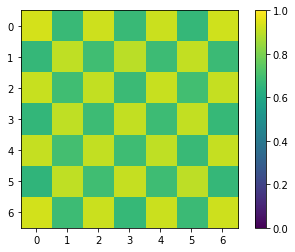

Standard deviation estimate for Gibbs sampling:
[[ 0.00428155  0.00646047  0.00513657  0.00722397  0.00494001  0.00606265
   0.00330268]
 [ 0.0076515   0.00499279  0.0067953   0.00425206  0.0073663   0.00321901
   0.00701053]
 [ 0.00540725  0.00734835  0.00323611  0.00688422  0.00497448  0.00509387
   0.00330841]
 [ 0.00749135  0.00331203  0.00623156  0.00408808  0.00573969  0.0028786
   0.00797649]
 [ 0.00338023  0.00784369  0.00511238  0.00503444  0.00602358  0.00746127
   0.00509729]
 [ 0.0059223   0.00297348  0.00762859  0.00169941  0.00462987  0.00325729
   0.00605603]
 [ 0.00389363  0.00639513  0.00187788  0.00685962  0.00292467  0.00863074
   0.00253299]]


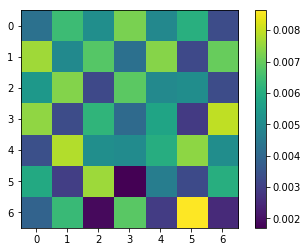

[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4]
KL divergence for mean field:


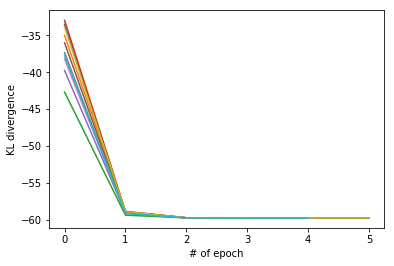

Mean estimate for mean field :
[[ 0.93098786  0.67246631  0.92267997  0.6715609   0.92277805  0.67260535
   0.93108453]
 [ 0.67258553  0.91428599  0.69712549  0.91528965  0.69715971  0.91445567
   0.67269988]
 [ 0.92267925  0.69708718  0.91624918  0.6966458   0.91628036  0.69724886
   0.92285572]
 [ 0.67148279  0.91528094  0.69662526  0.91618236  0.6967089   0.91532097
   0.67175609]
 [ 0.9227789   0.69713827  0.9162036   0.69668824  0.91626095  0.6972292
   0.92287875]
 [ 0.67261153  0.91439489  0.69720716  0.91531918  0.69723194  0.91448729
   0.67272317]
 [ 0.93107253  0.67266346  0.92285323  0.67176729  0.9228788   0.6727225
   0.93110583]]


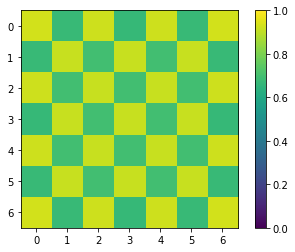

Standard deviation estimate for mean field:
[[  8.51757305e-05   1.19774069e-04   7.70085985e-05   9.28970125e-05
    6.27004417e-05   5.66267740e-05   1.36181142e-05]
 [  1.07083138e-04   8.24479198e-05   5.99929428e-05   7.82983463e-05
    7.00574265e-05   3.41203343e-05   2.42668499e-05]
 [  8.05369001e-05   7.42725695e-05   7.35172658e-05   8.15633503e-05
    4.82220290e-05   2.88099984e-05   1.46494936e-05]
 [  1.17103515e-04   6.22412988e-05   8.16817133e-05   5.75881804e-05
    4.15907349e-05   3.06107168e-05   2.78050142e-05]
 [  4.59022245e-05   6.64319701e-05   5.73754460e-05   5.13511520e-05
    3.74062403e-05   3.19509280e-05   7.11901096e-06]
 [  4.75571894e-05   4.05874716e-05   4.40932475e-05   3.21209588e-05
    3.13872055e-05   1.07257990e-05   8.45292756e-06]
 [  1.47923392e-05   3.21746710e-05   1.57925884e-05   2.47167584e-05
    8.29562842e-06   9.65150331e-06   1.44907093e-06]]


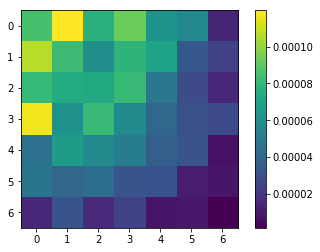

L1 distance between the mean field estimated momentsand the Gibbs estimates : 0.00778


In [398]:
if __name__ == "__main__":
    
    grid_dims = np.array([7,7])
    
    n_burn_in_epochs = 1000
    n_epochs = 5000
    n_rep_stddev = 10
    n_rep_mean_field = 10
    
    ising_gibbs = IsingGibbs(grid_dims)
    mean_gibbs = ising_gibbs.gibbs_sampling(n_burn_in_epochs, n_epochs, n_rep_stddev)

    ising_mean_field = IsingMeanField(grid_dims)
    mean_mean_field = ising_mean_field.mean_field(n_rep_mean_field)
    
    print("L1 distance between the mean field estimated moments"
              "and the Gibbs estimates : %.5f" % l1_distance(mean_gibbs, mean_mean_field))
